In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/.julia/dev/StableManipulation/Project.toml`


In [2]:
using LinearAlgebra
using ForwardDiff
using OrdinaryDiffEq
using Plots
using Convex, SCS
using JLD
using StableManipulation

In [3]:
# (1) system properties and contact

const g = 9.81

const m = 1
const μ = 0.5 # pusher-slider friction coefficient

const w = 1.0 # width of the slider (x axis)
const h = 1.0 # height of the slider (y aixs)

const M = [m 0 0; 0 m 0; 0 0 m*((h/2)^2+(w/2)^2)/3] # inertia matrix

const A_ls = [1 0 0; 0 1 0; 0 0 1.5] # ellipsoid limit surface

const modes = [0 0; # free
            1 0; # sticking
            1 1; # right slide 
            1 -1] # left slide

const n_contacts = 1 

# simulation step size
const Δt = 0.05
# tolerance for contacts
const tol_c = 1e-5

# q = [x_s, y_s, θ_s, x_p, y_p]


1.0e-5

In [4]:
include("../models/model_utils.jl")

rk4_step (generic function with 1 method)

In [189]:
# only consider the block is pushed on the edge of x = -w/2 
function compute_a(q)
    p = q[4:5]
    # p1 = R_2D(q[3])*[-w/2; -h/2] + q[1:2]
    # p2 = R_2D(q[3])*[-w/2; h/2] + q[1:2]
    # d = -((p2[1] - p1[1])*(p1[2] - p[2]) - (p1[1] - p[1])*(p2[2] - p1[2]))/w

    p_o = R_2D(q[3])'*(p-q[1:2])
    d = -(p_o[1] - (-w/2))
    if (abs(d) < 1e-7)
        d = 0.0
    end
    return d
end

compute_a (generic function with 1 method)

In [6]:
function compute_A(q)
    A = ForwardDiff.gradient(compute_a, q)
    return A
end

compute_A (generic function with 1 method)

In [7]:
function motion_cone(vp, p)
    # vp: pusher velocity in the body frame
    # p: pusher location in the body frame (assume pusher make contact with x = -w/2 edge)

    # return (pusher motion relative to the slider)
    # 0 sticking, 1 right slide, -1 left slide

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    Vl = A_ls*Fl
    Vr = A_ls*Fr

    vl = Jp*Vl # vl[1] > 0, vl[2] < 0, slider sliding to the left of the pusher
    vr = Jp*Vr # vr[1] > 0, vr[2] > 0, slider sliding to the right of the pusher 

    if vp[2]/vp[1] > vr[2]/vr[1]
        return 1
    elseif vp[2]/vp[1] < vl[2]/vl[1]
        return -1
    end
    
    return 0
end

motion_cone (generic function with 1 method)

In [8]:
# quasi-static: x = q
function solveEOM(x, u_control)
    # u_control: velocity of the pusher in the world frame
    if (abs(compute_a(x)) > tol_c)
        return [0;0;0;u_control]
    end

    R_WO = R_2D(x[3])
    vp = R_WO'*u_control
    p = R_WO'*(x[4:5] .- x[1:2])

    if (vp[1] < 0) || (abs(p[2]) > h/2)
        # leaving
        return [0;0;0;u_control]
    end
    
    mc = motion_cone(vp, p)

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    if mc == 0
        # println("stick")
        t = [-p[2];p[1];-1]
        D = [Jp' inv(A_ls)*t]'
        Vp = [vp;0]
        V = inv(D)*Vp
    else
        if mc == 1
            # println("right slide")
            V = A_ls*Fr
        else
            # println("left slide")
            V = A_ls*Fl
        end
        k = vp[1]/(V[1] - V[3]*p[2])
        V = k*V
    end

    V_w = [R_WO [0;0];0 0 1]*V

    return [V_w; u_control]
end

solveEOM (generic function with 1 method)

In [9]:
function continuous_dynamics_differentiable(x, u, mode)
    # u_control: velocity of the pusher in the world frame

    if mode[1] == 0
        return [0;0;0;u]
    end

    R_WO = R_2D(x[3])
    vp = R_WO'*u
    p = R_WO'*(x[4:5] .- x[1:2])

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    if mode[2] == 0
        # println("stick")
        t = [-p[2];p[1];-1]
        D = [Jp' inv(A_ls)*t]'
        Vp = [vp;0]
        V = inv(D)*Vp
    else
        if mode[2] == 1
            # println("right slide")
            V = A_ls*Fr
        else
            # println("left slide")
            V = A_ls*Fl
        end
        k = vp[1]/(V[1] - V[3]*p[2])
        V = k*V
    end

    V_w = [R_WO [0;0];0 0 1]*V

    return [V_w; u]
end

continuous_dynamics_differentiable (generic function with 1 method)

In [10]:
function discrete_dynamics(x, u, mode)
    xn = rk4_step((_x,_u)->continuous_dynamics_differentiable(_x,_u,mode),x,u)
    return xn
end

discrete_dynamics (generic function with 1 method)

In [11]:
function ode_dynamics!(dx, x, p, t)
    # p from integrator: (contact mode, controller, t_control, h_control, u_control)
    

    contactMode = p[1]
    controller = p[2]
    t_control = p[3][1]
    h_control = p[4]
    u_control = zeros(2)
    u_control .= p[5]
    
    if t > (t_control + h_control)
        p[3] .= [Float64(t)]
        u_control = controller(x, t)
        p[5] .= u_control
    end
    

    dx .= solveEOM(x, u_control)

end

ode_dynamics! (generic function with 1 method)

In [190]:
function ode_conditions(out, x, t, integrator)
    c = compute_a(x)
    out .= c
end

ode_conditions (generic function with 1 method)

In [191]:
function ode_affect_neg!(integrator, idx)
    # if debug == true
    #     println("down crossing.")
    # end
    # u_control = controller(x)
    # integrator.p[5] .= u_control
end

ode_affect_neg! (generic function with 1 method)

In [192]:
function push_controller(x,t)
    return [1;0]
end

push_controller (generic function with 1 method)

In [124]:
# straight line pushing 
pusher_u_ref = [0.5;0]
nominal_mode = [1,0]
xref = [0,0,0,-w/2,0]

5-element Vector{Float64}:
  0.0
  0.0
  0.0
 -0.5
  0.0

In [16]:
# LQR controller
A_lqr = ForwardDiff.jacobian(_x->discrete_dynamics(_x, pusher_u_ref, nominal_mode), xref)
B_lqr = ForwardDiff.jacobian(_u->discrete_dynamics(xref, _u, nominal_mode), pusher_u_ref)
Q_lqr = Diagonal([1.0;1.0;1.0;1.0;1.0])
R_lqr = Diagonal([0.1;0.1])
Ks, _ = StableManipulation.riccati(A_lqr,B_lqr,Q_lqr,R_lqr,Q_lqr,50)
K_lqr = Ks[1]

2×5 Matrix{Float64}:
 2.0   0.0        0.0      2.0  0.0
 0.0  -0.255704  -1.92241  0.0  3.04558

In [17]:
xrefs = zeros(20, 5)
for k = 1:20
    xrefs[k,:] .= [k*0.1,0,0,-w/2+k*0.1,0]
end

In [73]:
xrefs

20×5 Matrix{Float64}:
 0.1  0.0  0.0  -0.4  0.0
 0.2  0.0  0.0  -0.3  0.0
 0.3  0.0  0.0  -0.2  0.0
 0.4  0.0  0.0  -0.1  0.0
 0.5  0.0  0.0   0.0  0.0
 0.6  0.0  0.0   0.1  0.0
 0.7  0.0  0.0   0.2  0.0
 0.8  0.0  0.0   0.3  0.0
 0.9  0.0  0.0   0.4  0.0
 1.0  0.0  0.0   0.5  0.0
 1.1  0.0  0.0   0.6  0.0
 1.2  0.0  0.0   0.7  0.0
 1.3  0.0  0.0   0.8  0.0
 1.4  0.0  0.0   0.9  0.0
 1.5  0.0  0.0   1.0  0.0
 1.6  0.0  0.0   1.1  0.0
 1.7  0.0  0.0   1.2  0.0
 1.8  0.0  0.0   1.3  0.0
 1.9  0.0  0.0   1.4  0.0
 2.0  0.0  0.0   1.5  0.0

In [127]:
function lqr_controller(x,t)
    # idx = argmin(sum((xrefs - repeat(x, outer = [1, 20])').^2,dims=2))[1]
    idx = min(ceil(Int,(t+1e-5)/0.2), 20)
    xref_k = xrefs[idx,:]
    u = pusher_u_ref .- K_lqr*(x.-xref_k)
    return u
end

lqr_controller (generic function with 1 method)

## Hybrid controller

In [19]:
# Lyapunov function
function V(x, x_ref)
    v = 0.5*(x.-x_ref)'*Q_lqr*(x.-x_ref)
    return v
end

function dVdx(x, x_ref)
    return Q_lqr*(x.-x_ref)
end

dVdx (generic function with 1 method)

In [20]:
function domain(x, u, contactMode)
    d = compute_a(x)

    R_WO = R_2D(x[3])
    vp = R_WO'*u

    p = R_WO'*(x[4:5] .- x[1:2])

    Jp = [1 0 -p[2]; 0 1 p[1]]

    fl = [1; -μ]
    fr = [1; μ]

    Fl = Jp'*fl
    Fr = Jp'*fr

    Vl = A_ls*Fl
    Vr = A_ls*Fr

    vl = Jp*Vl # vl[1] > 0, vl[2] < 0, slider sliding to the left of the pusher
    vr = Jp*Vr # vr[1] > 0, vr[2] > 0, slider sliding to the right of the pusher 

    if contactMode[1] == 0
        # separating/free contact
        # vp[1] < 0
        # d >= 0
        ineqs = [-vp[1];d]
        eqs = zeros(0)    
    else
        if contactMode[2] == 0
            # vp[2]/vp[1] < vr[2]/vr[1]
            # vp[2]/vp[1] > vl[2]/vl[1]
            if abs(vp[1]) < 1e-6
                ineqs = [ - vp[2]; vp[2]; vp[1]]
            else
                ineqs = [vr[2]/vr[1] - vp[2]/vp[1]; vp[2]/vp[1] - vl[2]/vl[1]; vp[1]]
            end
            eqs = [d]
        else 
            if contactMode[2] == -1
                # vp[2]/vp[1] < vl[2]/vl[1]
                if abs(vp[1]) < 1e-6
                    ineqs = [-vp[2]; vp[1]]
                else
                    ineqs = [vl[2]/vl[1] - vp[2]/vp[1]; vp[1]]
                end
                eqs = [d]
            else
                # vp[2]/vp[1] > vr[2]/vr[1]
                if abs(vp[1]) < 1e-6
                    ineqs = [vp[2]; vp[1]]
                else
                    ineqs = [vp[2]/vp[1] - vr[2]/vr[1]; vp[1]]
                end
                eqs = [d]
            end
        end
    end
    
    return ineqs, eqs
end  

domain (generic function with 1 method)

In [21]:
const n_modes = size(modes, 1)

const n_u = 2
const n_β = 15
const n_α = n_modes

4

In [22]:
fuz = 0.0

function hybrid_constraints_matrix(x, u_ref, x_ref)
    n = n_u + n_β + n_α
    m = n_modes

    A = zeros(m, n)
    b = zeros(m)

    nominal_mode = [1,0] # sticking pusher-slider contact

    β_idx = 1

    Vx = dVdx(x, x_ref)
    Vv = V(x, x_ref)

    for k = 1:n_modes 
        mode = modes[k,:]
        d_ineq, d_eq = domain(x, u_ref, mode)

        n_ineq = size(d_ineq, 1)
        n_eq = size(d_eq, 1)

        dfdu = ForwardDiff.jacobian(_u->continuous_dynamics_differentiable(x, _u, mode), u_ref)

        b[k] = -Vx'*continuous_dynamics_differentiable(x, u_ref, mode)

        A[k, n_u+n_β+k] = -Vv
        A[k, 1:n_u] = -Vx'*dfdu
        A[k, β_idx:β_idx+n_ineq-1] .= -(d_ineq .+ fuz)
        A[k, β_idx+n_ineq:β_idx+n_ineq+n_eq-1] .= -(d_eq .+ fuz)
        A[k, β_idx+n_ineq+n_eq:β_idx+n_ineq+2*n_eq-1] .= d_eq .- fuz

        β_idx += n_ineq + 2*n_eq
        
    end

    return A, b

end


hybrid_constraints_matrix (generic function with 1 method)

In [202]:
function hybrid_controller(x, t)
    
    idx = min(ceil(Int,(t+1e-5)/0.2), 20)
    xref_k = xrefs[idx,:]

    u_ref = [0.5,0]

    α_ref = 5.0

    n_var = n_u + n_β + n_α

    u = u_ref

    stop_thr = 1e-3

    du = [1,1]

    iter = 0

    while any(abs.(du) .> 1e-2) && (iter < 100)

        iter = iter + 1

        z = Variable(n_var)
        
        A, b = hybrid_constraints_matrix(x, u, xref_k)

        problem = minimize(sumsquares(z - [zeros(n_u + n_β); α_ref*ones(n_α)]))
        problem.constraints += A*z + b >= 0
        problem.constraints += z[n_u+1:end] >= 0
        problem.constraints += z[1:n_u] > -0.2
        problem.constraints += z[1:n_u] < 0.2
        # problem.constraints += z[1:n_u] <= 10
        # problem.constraints += z[1:n_u] >= -10

        Convex.solve!(problem, () -> SCS.Optimizer(verbose=false))
        
        z_sol = evaluate(z)

        if any(isnan.(z_sol)) || sum(z_sol) == Inf # infeasible
            # z_sol = zeros(n_var)
            println("Infeasible: ", x, " t ", t)
            u .= [0.0,0.0]
            break
        end
    
        du = z_sol[1:n_u]
        
        # println("iter ", iter, ": du = ", du)

        u .= u .+ du
    end

    println("u, ", u)

    return u
end

hybrid_controller (generic function with 1 method)

In [154]:
hybrid_controller([0.1;0;0;-0.4;0.1], 0.0)

u, [0.5591152480861931, -0.24994398597129547]


2-element Vector{Float64}:
  0.5591152480861931
 -0.24994398597129547

In [158]:
ceil(Int,(0.3553154692729009+1e-5)/0.2)

2

In [159]:
xrefs[2,:]

5-element Vector{Float64}:
  0.2
  0.0
  0.0
 -0.3
  0.0

In [160]:
compute_a([0.5404297117798483, -0.08807322369851396, -0.021952042399671454, 0.04274373678794523, 0.022811198217499242])

8.358514103079528e-9

In [136]:
lqr_controller([0;0;0;-w/2-0.05;0.1], 0.0)

2-element Vector{Float64}:
  0.9999999997135423
 -0.3045579249970693

In [208]:
controller = hybrid_controller
h_control = Δt

tspan = (0.0, 5)

x0 = [0;0;0;-w/2-0.1;0.1]

prob = ODEProblem(ode_dynamics!, x0, tspan, ([0], controller, [0.0], h_control/2, controller(x0,0)))
cb = VectorContinuousCallback(ode_conditions, nothing, ode_affect_neg!, 1)

sol = solve(prob, Tsit5(); callback = cb, abstol=1e-15,reltol=1e-15, adaptive=false,dt=Δt/10)

println("Simulation status: ", sol.retcode)

u, [0.710268961195225, -0.03719151255833299]
u, [0.6704288266790454, -0.01951679428725442]
u, [0.6598881473849121, -0.008693120559656037]
u, [0.6718738425522746, -9.518800272749293e-6]
u, [0.9206476933567679, 9.349307121698619e-6]
u, [0.7438064539625465, -2.6381614766645033e-7]
u, [0.6399814096348512, 2.0602182321736717e-6]
u, [0.6416654016552327, -1.0493430735617532e-7]
u, [0.7444445395400348, -2.0710637518455984e-5]
u, [0.6527429622593572, -5.458234422865792e-6]
u, [0.6862285796927122, 1.4558321324960947e-6]
u, [0.5550993268419796, -0.18024703516937246]
u, [0.6487142471831033, 1.4171250040206143e-6]
u, [0.6794152748733937, 9.17094720823764e-6]
u, [0.5636078487013719, -0.17301798477072394]
Infeasible: [0.41350107422412746, -0.03554694851801814, -0.04044347093354123, -0.08217907310485613, 0.08133351955758142] t 0.7608878125319232
u, [0.0, 0.0]
u, [0.658810237883149, 5.625006060745514e-7]
u, [0.6515062513708889, 1.067343871278501e-5]
u, 

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


[0.6750260372837056, -0.11062083701955742]
Infeasible: [0.5085713984513619, -0.0456685905093284, -0.050007119726720686, 0.014031660071929703, 0.0759469823403269] t 0.9630228125319235
u, [0.0, 0.0]
u, [0.6952380142517129, 2.42024486482074e-6]
u, [0.7138289231120936, -6.628564244900669e-5]
u, [0.6862508476171327, -0.20129223380018124]
Infeasible: [0.6132394988225008, -0.06185189616687686, -0.057570165497407594, 0.11963326748588762, 0.06350049454295623] t 1.1671928125319198
u, [0.0, 0.0]
u, [0.7128306511320525, -2.651819219837906e-6]
u, [0.7939318693687359, -0.001018549568721258]
u, [0.6017876504324692, -0.6409204833331791]
Infeasible: [0.7227161742633842, -0.08420945944333526, -0.06195015512283536, 0.22911921445452235, 0.034554928989716356] t 1.3713878125319154
u, [0.0, 0.0]
u, 

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


[0.7417925756064107, 1.7534158046615e-5]
u, [0.8475909539407522, -0.029384662361827334]
Infeasible: [0.7969456120013673, -0.08661083081816633, -0.07411655081544025, 0.3049935535177028, 0.040419757007624436] t 1.5258878125319122
u, [0.0, 0.0]


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [0.7956364482514049, -0.08648700756078849, -0.07395852808089634, 0.30366432077239797, 0.04046583944307218] t 1.5762879402364338
u, [0.0, 0.0]
u, [0.8345949450073187, -2.409081169829249e-6]
u, [0.959582819139257, -0.04406131296997003]


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [0.8948612754144697, -0.09513386918444278, -0.08697486382563516, 0.40458280301820576, 0.03821183486999895] t 1.728022812531908
u, [0.0, 0.0]
Infeasible: [0.8938200495300124, -0.09502312441622572, -0.08684808351540689, 0.4035246747226681, 0.03826042111087588] t 1.7808878125319068
u, [0.0, 0.0]
u, [0.9177753384815837, -2.2887364447575203e-5]
u, [1.0282473651374584, -0.03629999006467514]


┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [0.9870543931583436, -0.10356409968509188, -0.09966717509972614, 0.49850771307233405, 0.03599349740787759] t 1.9321928125319034
u, [0.0, 0.0]
u, [0.7602843132028244, -2.1991530185904176]
u, [1.1853091288090316, 0.1735521207017096]
u, 

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


[3.3435655115124763, 0.6005796469099447]
u, [17.286948717133527, 19.999952665815233]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.569934262975724, 0.8713405428735551] t 2.1870833546221595
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 2.2378883546221586
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 2.2887183546221572
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 2.3415833546221565
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 2.391983482326678
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 2.442083354622154
u, [0.0, 0.0]
Infeasible: [1.0364361

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status I

Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.053718354622141
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.10658335462214
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.1569834823266616
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.207083354622138
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.257888354622137
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.3087183546221355
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.63887004065496

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status I

Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.6165833546221293
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.6669834823266507
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.717083354622127
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.767888354622126
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.8187183546221246
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.871583354622124
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654

┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 3.9720833546221215
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.02288835462212
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.07371835462212
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.1265833546221184
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.17698348232664
u, [0.0, 0.0]


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.227083354622116
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.277888354622115
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.328718354622114
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.381583354622113
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.431983482326634
u, [0.0, 0.0]


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.482083354622111
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.532888354622109
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.583718354622109
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.636583354622108
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.686983482326629
u, [0.0, 0.0]


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.737083354622105
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.787888354622104
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.838718354622103
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.891583354622102
u, [0.0, 0.0]
Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.9419834823266235
u, [0.0, 0.0]


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263
┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


Infeasible: [1.036436102313051, -0.13247566849673556, -0.08542023850244092, 1.368998504914257, 0.638870040654965] t 4.9920833546221
u, [0.0, 0.0]
Simulation status: Success


┌ Warning: Problem status INFEASIBLE; solution may be inaccurate.
└ @ Convex /home/xianyi/.julia/packages/Convex/uI27T/src/solution.jl:263


In [194]:
function boxshape(q)
    p1 = q[1:2] + R_2D(q[3])*[w/2;h/2]
    p2 = q[1:2] + R_2D(q[3])*[w/2;-h/2]
    p3 = q[1:2] + R_2D(q[3])*[-w/2;-h/2]
    p4 = q[1:2] + R_2D(q[3])*[-w/2;h/2]
    pp = [p1 p2 p3 p4]
    return Shape(pp[1,:], pp[2,:])
end

function animation(x, n; interval_n = 1, fps = 30)
    anim = Plots.Animation()
    for k = 1:Int(floor(n/interval_n)+1)
        i = (k-1)*interval_n+1
        p = plot(boxshape([x[i][1],x[i][2],x[i][3]]), aspect_ratio=:equal, c=:gray, opacity=.7, legend=false)
        scatter!(p,[x[i][4]],[x[i][5]], markersize=5, xlims=(-2,10), ylims=(-2,2))
        frame(anim, p)
    end
    p = plot(boxshape([x[n][1],x[n][2],x[n][3]]), aspect_ratio=:equal, c=:gray, opacity=.7, legend=false)
    scatter!(p,[x[n][4]],[x[n][5]], markersize=5, xlims=(-2,10), ylims=(-2,2))
    frame(anim, p)

    Plots.gif(anim, "anim.gif", fps = fps)
end


animation (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/xianyi/.julia/dev/StableManipulation/example/anim.gif
└ @ Plots /home/xianyi/.julia/packages/Plots/FI0vT/src/animation.jl:114


Plots.AnimatedGif("/home/xianyi/.julia/dev/StableManipulation/example/anim.gif")
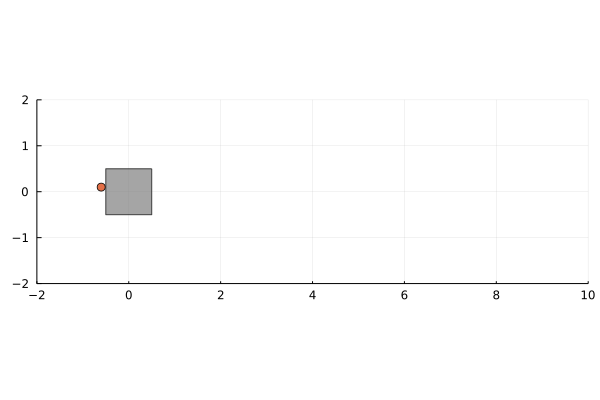

In [206]:
animation(sol.u,length(sol.t)-1, interval_n = 10)
# animation(sol.u,250, interval_n = 1)